<a href="https://colab.research.google.com/github/MasaAsami/LTsandox/blob/main/notebooks/IVnotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# randomized-encouragement design
- 操作変数法と無作為化推奨デザインの概説

In [1]:
# @title import pkg
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

import matplotlib.pyplot as plt

plt.style.use("ggplot")

import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# @title sim data

def sim_df(true_effect=1, n=500, seed=0) -> pd.DataFrame:
    np.random.seed(seed=seed)
    _iv = np.random.choice([1, 0], n)
    _x = np.random.normal(loc=0, scale=3, size=n)

    _temp = -0.5 + 0.5 * _iv + 0.5 * _x + np.random.normal(loc=0, scale=0.01, size=n)
    _t_prob = 1 / (1 + np.exp(-_temp))
    _t = np.where(_t_prob > 0.5, 1, 0)

    _y = 1 + true_effect * _t - 5 * _x + np.random.normal(loc=0, scale=0.1, size=n)

    return pd.DataFrame({"latent_x": _x, "iv": _iv, "t": _t, "y": _y})

In [4]:
N = 5000
TRUE_EFFECT = 10

df = sim_df(true_effect=TRUE_EFFECT, n=N, seed=0) 
df.sample(5)

,latent_x,iv,t,y
2298,2.577992,1,1,-1.952472
2599,1.256916,0,1,4.717017
3445,-3.694655,0,0,19.640854
2069,5.531100,1,1,-16.685791
3093,3.453454,0,1,-6.301546


In [5]:
df.groupby("t")["y"].describe().T

t,0,1
count,2870.000000,2130.000000
mean,11.173053,-2.379680
std,9.634723,8.773237
min,-4.046738,-45.973157
25%,3.645732,-7.423094
50%,9.591128,-0.797898
75%,16.847102,4.154323
max,57.203233,11.170376


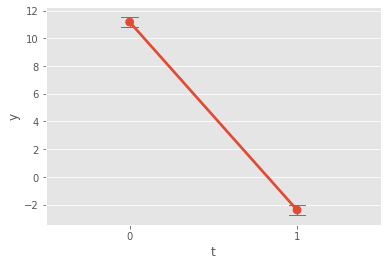

In [6]:
sns.pointplot(
    data=df,
    x="t",
    y="y",
    dodge=True,
    markers=["o", "s"],
    capsize=0.1,
    errwidth=1,
)

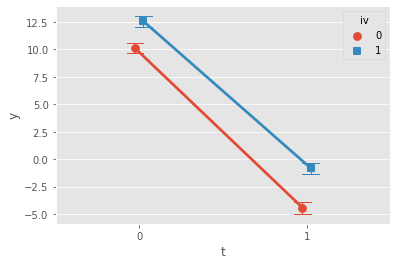

In [7]:
sns.pointplot(
    data=df,
    x="t",
    y="y",
    hue="iv",
    dodge=True,
    markers=["o", "s"],
    capsize=0.1,
    errwidth=1,
)

## T のみで回帰した場合

In [8]:
_regression = smf.glm(
    formula="y ~ C(t)", data=df, family=sm.families.Gaussian()
).fit()

print("介入効果 (naive OLS): ", _regression.params[1])
print("詳細: \n", _regression.summary().tables[1])

介入効果 (naive OLS):  -13.552732865956429
詳細: 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1731      0.173     64.518      0.000      10.834      11.512
C(t)[T.1]    -13.5527      0.265    -51.079      0.000     -14.073     -13.033


## 理想：もしXを観測できたなら

In [9]:
_regression = smf.glm(
    formula="y ~ C(t) + latent_x", data=df, family=sm.families.Gaussian()
).fit()

print("介入効果 (perfect OLS): ", _regression.params[1])
print("詳細: \n", _regression.summary().tables[1])

介入効果 (perfect OLS):  10.011950869840312
詳細: 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9973      0.002    417.662      0.000       0.993       1.002
C(t)[T.1]     10.0120      0.005   2216.254      0.000      10.003      10.021
latent_x      -5.0020      0.001  -6667.024      0.000      -5.003      -5.001


# 2段階推定 2SLS
###  “forbidden regression”  (Wooldridge 2010) 問題には注意
- 多分ML出身者よくやりそうな過ち
- Wooldridge, Jeffrey M. 2010. Econometric Analysis of Cross Section and Panel Data. Cambridge, MA: MIT press.).をチェック
- もしくは、[The Effect](https://theeffectbook.net/ch-InstrumentalVariables.html?panelset=python-code)

In [11]:
# @title forbidden regression
iv_df = df.copy()

# 1st regression
t_regression = smf.glm(
    formula="C(t) ~ iv", data=iv_df, family=sm.families.Binomial()
).fit()

iv_df["t_hat"] = t_regression.predict(iv_df)

# 2nd regression
y_regression = smf.glm(
    formula="y ~ t_hat", data=iv_df, family=sm.families.Gaussian()
).fit()
print("真の値: ", TRUE_EFFECT)
print("forbidden regression : ",  y_regression.params[1])

真の値:  10
forbidden regression :  -7.828289669590664


気持ち悪いけど、gaussianでモデル作る

In [15]:
# 1st regression
t_regression = smf.glm(
    formula="t ~ iv", data=iv_df, family=sm.families.Gaussian()
).fit()
iv_df["t_hat"] = t_regression.predict(iv_df)

# 2nd regression
y_regression = smf.glm(
    formula="y ~ t_hat", data=iv_df, family=sm.families.Gaussian()
).fit()
print("真の値: ", TRUE_EFFECT)
print("2SLS : ",  y_regression.params[1])

真の値:  10
2SLS :  7.828289669590308


## 検算

In [14]:
# IV定義
print(
    "IV estimator : ", iv_df[["iv", "y"]].cov().values[0, 1] / iv_df[["iv", "t"]].cov().values[0, 1]
)

# Wald estimator
_wald_up = iv_df.query("iv==1")["y"].mean() - iv_df.query("iv==0")["y"].mean()
_wald_dwn = iv_df.query("iv==1")["t"].mean() - iv_df.query("iv==0")["t"].mean()

print("Wald estimator : ", _wald_up / _wald_dwn)

IV estimator :  7.828289669590331
Wald estimator :  7.828289669590349


# シミュレーション
- サウンプルサイズが十分大きければ、IV推定法は一致性が成立する

In [16]:
# @title 10~5000までシミュレーション
sample_n_list = [10 * i for i in range(1, 501)]
result_dict = {}
ols_dict = {}
naive_dict = {}
for _n in sample_n_list:
    _df = sim_df(true_effect=TRUE_EFFECT, n=_n, seed=_n)
    result_dict[_n] = _df[["iv", "y"]].cov().values[0,1] / _df[["iv", "t"]].cov().values[0,1]
    
    _regression = smf.glm(
        formula="y ~ C(t) + latent_x", data=_df, family=sm.families.Gaussian()
    ).fit()
    ols_dict[_n] = _regression.params[1]
    
    _regression = smf.glm(
        formula="y ~ C(t)", data=_df, family=sm.families.Gaussian()
    ).fit()
    naive_dict[_n] = _regression.params[1]

操作変数法 推定値


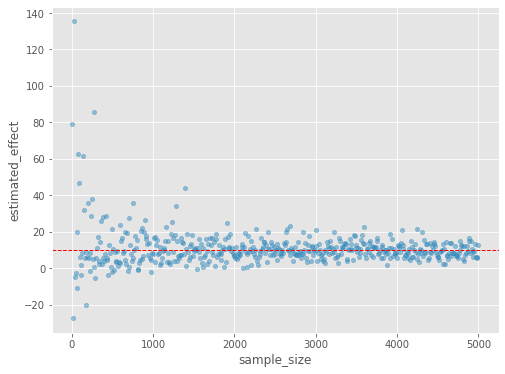

In [17]:
sim_result = pd.DataFrame(result_dict, index=["estimated_effect"]).T.reset_index()
sim_result.columns = ["sample_size", "estimated_effect"]

sim_result.plot.scatter(x="sample_size", y="estimated_effect", alpha=0.5, figsize=(8, 6))
plt.axhline(TRUE_EFFECT, color="r", linestyle="dashed", linewidth=1)
print("操作変数法 推定値")

パーフェクトOLS 推定値


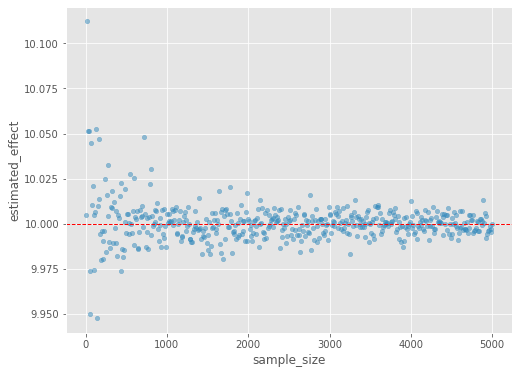

In [18]:
ols_result = pd.DataFrame(ols_dict, index=["estimated_effect"]).T.reset_index()
ols_result.columns = ["sample_size", "estimated_effect"]

ols_result.plot.scatter(x="sample_size", y="estimated_effect", alpha=0.5, figsize=(8, 6))
plt.axhline(TRUE_EFFECT, color="r", linestyle="dashed", linewidth=1)
print("パーフェクトOLS 推定値")

naive OLS 推定値


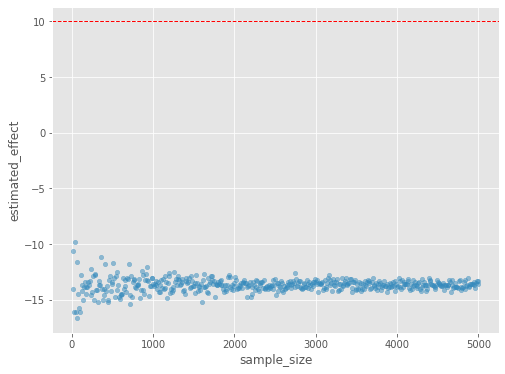

In [19]:
naive_result = pd.DataFrame(naive_dict, index=["estimated_effect"]).T.reset_index()
naive_result.columns = ["sample_size", "estimated_effect"]

naive_result.plot.scatter(x="sample_size", y="estimated_effect", alpha=0.5, figsize=(8, 6))
plt.axhline(TRUE_EFFECT, color="r", linestyle="dashed", linewidth=1)
print("naive OLS 推定値")